In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [ ]:
import os
import tensorflow as tf

# Define your image size and batch size
IMAGE_SIZE = 256
BATCH_SIZE = 32

# Use an absolute path to the directory
directory_path = r"D:\mini project ppt\image processing\datasets\eye ds 2\gaussian_filtered_images\gaussian_filtered_images"

# Check if the directory exists
if os.path.exists(directory_path):
    # Load the dataset
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory_path,
        seed=123,
        shuffle=True,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE
    )
else:
    print(f"Directory '{directory_path}' does not exist.")


Found 6384 files belonging to 5 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

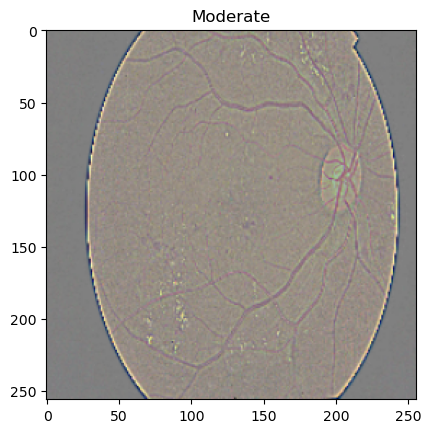

In [ ]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("on")

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

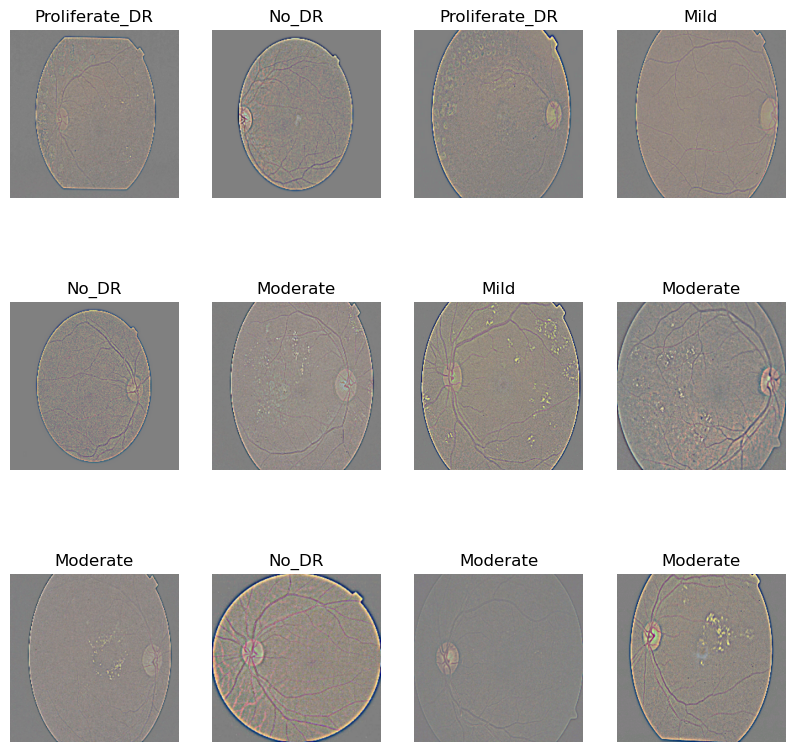

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

200

In [ ]:
train_size = 0.8
len(dataset)*train_size

160.0

In [ ]:
train_ds = dataset.take(69)
len(train_ds)

69

In [ ]:
test_ds = dataset.skip(69)
len(test_ds)

131

In [ ]:
val_size=0.1
len(dataset)*val_size

20.0

In [ ]:
val_ds = test_ds.take(9)
len(val_ds)

9

In [ ]:
test_ds = test_ds.skip(9)
len(test_ds)

122

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

160

In [ ]:
len(val_ds)

20

In [ ]:
len(test_ds)

20

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
from tensorflow.keras import layers, models
n_classes = 5
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                 

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
save_dir = r'C:\Users\darwin\Downloads\model_save'

# Ensure the directory exists or create it
os.makedirs(save_dir, exist_ok=True)

# Save the entire model to a file using the recommended .keras format
model_path = os.path.join(save_dir, 'entire_model.keras')
model.save(model_path)

# Save the model weights only using the recommended .h5 format
weights_path = os.path.join(save_dir, 'model_weights.h5')
model.save_weights(weights_path)


In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15
160/160 [==============================] - 959s 6s/step - loss: 1.7792 - accuracy: 0.5027 - val_loss: 0.9699 - val_accuracy: 0.6453
Epoch 2/15
160/160 [==============================] - 820s 5s/step - loss: 1.0181 - accuracy: 0.6338 - val_loss: 0.9523 - val_accuracy: 0.6469
Epoch 3/15
160/160 [==============================] - 882s 5s/step - loss: 0.9536 - accuracy: 0.6530 - val_loss: 0.8669 - val_accuracy: 0.6641
Epoch 4/15
160/160 [==============================] - 875s 5s/step - loss: 0.9373 - accuracy: 0.6587 - val_loss: 0.8761 - val_accuracy: 0.6641
Epoch 5/15
160/160 [==============================] - 882s 5s/step - loss: 0.9199 - accuracy: 0.6614 - val_loss: 0.8537 - val_accuracy: 0.6828
Epoch 6/15
160/160 [==============================] - 932s 6s/step - loss: 0.8915 - accuracy: 0.6675 - val_loss: 0.8298 - val_accuracy: 0.6875
Epoch 7/15
160/160 [==============================] - 852s 5s/step - loss: 0.8960 - accuracy: 0.6656 - val_loss: 0.8585 - val_accuracy: 0.6812

In [ ]:
scores = model.evaluate(test_ds)

20/20 [==============================] - 54s 1s/step - loss: 0.7905 - accuracy: 0.7031


In [ ]:
scores

[0.7904859781265259, 0.703125]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 160}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

15

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

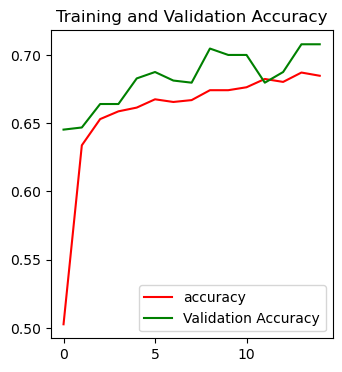

In [ ]:
Epoch = len(acc)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(range(Epoch), acc,color='red', label='accuracy')
plt.plot(range(Epoch), val_acc,color='green', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


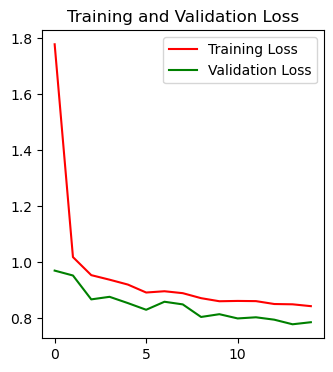

In [ ]:
EPOCHS=len(loss)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss,color='red', label='Training Loss')
plt.plot(range(EPOCHS), val_loss,color='green', label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: No_DR
1/1 [==============================] - 6s 6s/step
predicted label: No_DR


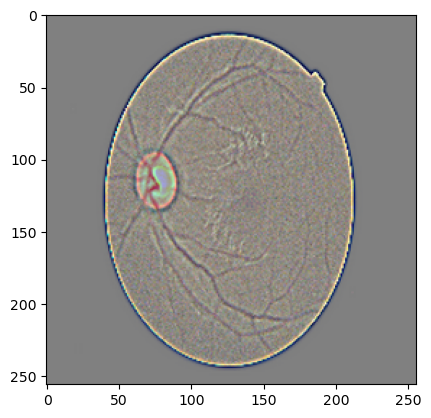

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 2s 2s/step


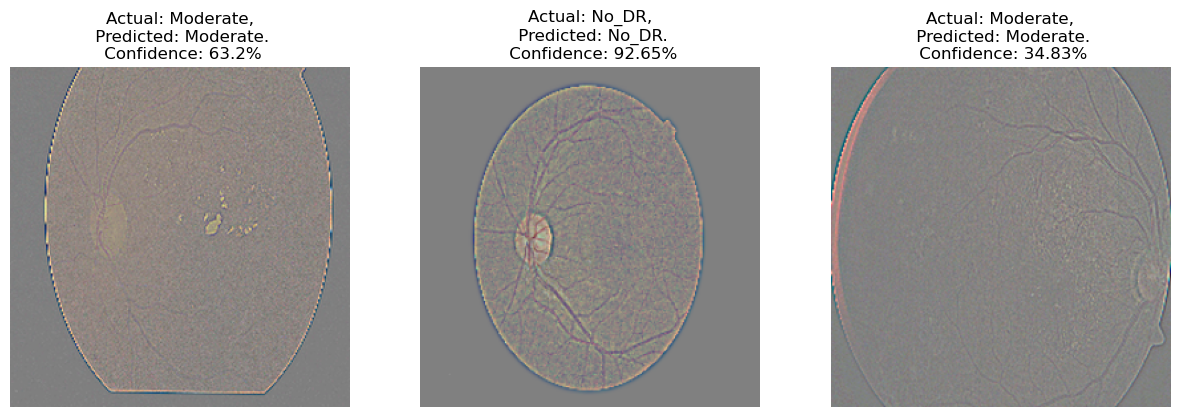

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")